aospy Tutorial
========
This notebook closely follows the descriptions, objects created, and code executed in the [examples](http://aospy.readthedocs.io/en/latest/examples.html) page in the documentation.  

Preliminaries
-------------
First we'll save the path to the example data in a local variable, since we'll be using it in several places below.

In [1]:
import os  # Python built-in package for working with the operating system
import aospy
rootdir = os.path.join(aospy.__path__[0], 'test', 'data', 'netcdf')

Now we'll use the fantastic [xarray](http://xarray.pydata.org/en/stable/) package to inspect the data:

In [2]:
import xarray as xr
xr.open_mfdataset(os.path.join(rootdir, '000[4-6]0101.precip_monthly.nc'),
                  decode_times=False)

<xarray.Dataset>
Dimensions:            (lat: 64, latb: 65, lon: 128, lonb: 129, nv: 2, time: 36)
Coordinates:
  * lonb               (lonb) float64 -1.406 1.406 4.219 7.031 9.844 12.66 ...
  * lon                (lon) float64 0.0 2.812 5.625 8.438 11.25 14.06 16.88 ...
  * latb               (latb) float64 -90.0 -86.58 -83.76 -80.96 -78.16 ...
  * lat                (lat) float64 -87.86 -85.1 -82.31 -79.53 -76.74 ...
  * nv                 (nv) float64 1.0 2.0
  * time               (time) float64 1.111e+03 1.139e+03 1.17e+03 1.2e+03 ...
Data variables:
    condensation_rain  (time, lat, lon) float32 dask.array<shape=(36, 64, 128), chunksize=(12, 64, 128)>
    convection_rain    (time, lat, lon) float32 dask.array<shape=(36, 64, 128), chunksize=(12, 64, 128)>
    time_bounds        (time, nv) float64 dask.array<shape=(36, 2), chunksize=(12, 2)>
    average_DT         (time) float64 dask.array<shape=(36,), chunksize=(12,)>
    zsurf              (time, lat, lon) float32 dask.array<shap

We see that, in this particular model, the variable names for these two forms of precipitation are "condensation_rain" and "convection_rain", respectively.  The file also includes the coordinate arrays ("lat", "time", etc.) that indicate where in space and time the data refers to.

Now that we know where and what the data is, we'll proceed through the workflow described in the [Using aospy](http://aospy.readthedocs.io/en/latest/using-aospy.html) section of the documentation.

Describing your data
===========

Runs and DataLoaders
-------------------

First we create a `Run` object that stores metadata about this simulation. This includes specifying where its files are located via an DataLoader object.

DataLoaders specify where your data is located and organized. Several types of DataLoaders exist, each for a different directory and file structure; see the [API reference](http://aospy.readthedocs.io/en/latest/api.html) for details.

For our simple case, where the data comprises a single file, the simplest DataLoader, a DictDataLoader, works well. It maps your data based on the time frequency of its output (e.g. 6 hourly, daily, monthly, annual) to the corresponding netCDF files via a simple dictionary:

In [3]:
from aospy.data_loader import DictDataLoader
file_map = {'monthly': os.path.join(rootdir, '000[4-6]0101.precip_monthly.nc')}
data_loader = DictDataLoader(file_map)

We then pass this to the `Run` constructor, along with a name for the run and an optional description.

Note: see the [API reference](http://aospy.readthedocs.io/en/latest/api.html) for other optional arguments for this and the other core aospy objects used in this tutorial.

In [4]:
from aospy import Run
example_run = Run(
    name='example_run',
    description='Control simulation of the idealized moist model',
    data_loader=data_loader
)

Models
------

Next, we create the `Model` object that describes the model in which the simulation was executed. One important attribute is grid_file_paths, which consists of a sequence (e.g. a tuple or list) of paths to netCDF files from which physical attributes of that model can be found that aren't already embedded in the output netCDF files.

For example, often the land mask that defines which gridpoints are ocean or land is outputted to a single, standalone netCDF file, rather than being included in the other output files. But we often need the land mask, e.g. to define certain land-only or ocean-only regions. This and other grid-related properties shared across all of a Model's simulations can be found in one or more of the files in grid_file_paths.

The other important attribute is runs, which is a list of the `Run` objects that pertain to simulations performed in this particular model.

In [5]:
from aospy import Model
example_model = Model(
    name='example_model',
    grid_file_paths=(
        os.path.join(rootdir, '00040101.precip_monthly.nc'),
        os.path.join(rootdir, 'im.landmask.nc')
    ),
    runs=[example_run]  # only one Run in our case, but could be more
)

Projects
--------

Finally, we associate the Model object with a Proj object. This is the level at which we specify the directories to which aospy output gets written.

In [6]:
from aospy import Proj
example_proj = Proj(
    'example_proj',
    direc_out='example-output',  # default, netCDF output (always on)
    tar_direc_out='example-tar-output', # output to .tar files (optional)
    models=[example_model]  # only one Model in our case, but could be more
)

This extra `Proj` level of organization may seem like overkill for this simple example, but it really comes in handy once you start using aospy for more than one project.

Defining physical quantities and regions
======================

Having now fully specified the particular data of interest, we now define the general physical quantities of interest and any geographic regions over which to aggregate results.

Physical variables
------------------

We'll first define `Var` objects for the two variables that we saw are directly available as model output:

In [7]:
from aospy import Var

precip_largescale = Var(
    name='precip_largescale',  # name used by aospy
    alt_names=('condensation_rain',),  # its possible name(s) in your data
    def_time=True,  # whether or not it is defined in time
    description='Precipitation generated via grid-scale condensation',
)
precip_convective = Var(
    name='precip_convective',
    alt_names=('convection_rain', 'prec_conv'),
    def_time=True,
    description='Precipitation generated by convective parameterization',
)

When it comes time to load data corresponding to either of these from one or more particular netCDF files, aospy will search for variables matching either `name` or any of the names in `alt_names`, stopping at the first successful one. This makes the common problem of model-specific variable names a breeze: if you end up with data with a new name for your variable, just add it to `alt_names`.

Warning: This assumes that the name and all alternate names are unique to that variable, i.e. that in none of your data do those names actually signify something else. If that was indeed the case, aospy can potentially grab the wrong data without issuing an error message or warning.

Next, we'll create functions that compute the total precipitation and convective precipitation fraction and combine them with the above Var objects to define the new Var objects:

In [8]:
def total_precip(condensation_rain, convection_rain):
    """Sum of large-scale and convective precipitation."""
    return condensation_rain + convection_rain

def conv_precip_frac(precip_largescale, precip_convective):
    """Fraction of total precip that is from convection parameterization."""
    total = total_precip(precip_largescale, precip_convective)
    return precip_convective / total.where(total)


precip_total = Var(
    name='precip_total',
    def_time=True,
    func=total_precip,
    variables=(precip_largescale, precip_convective),
)

precip_conv_frac = Var(
   name='precip_conv_frac',
   def_time=True,
   func=conv_precip_frac,
   variables=(precip_largescale, precip_convective),
)

Notice the `func` and `variables` attributes that weren't in the prior `Var` constuctors. These signify the function to use and the physical quantities to pass to that function in order to compute the quantity.

Note: although `variables` is passed a tuple of `Var` objects corresponding to the physical quantities passed to `func`, `func` should be a function whose arguments are the DataArray objects corresponding to those variables. aospy uses the `Var` objects to load the DataArrays and then passes them to the function.

This enables you to write simple, expressive functions comprising only the physical operations to perform (since the "data wrangling" part has been handled already).

Warning: order matters in the tuple of `Var` objects passed to the variables attribute: it must match the order of the call signature of the function passed to `func`.

E.g. in `precip_conv_frac` above, if we had mistakenly done `variables=(precip_convective, precip_largescale)`, the calculation would execute without error, but all of the results would be physically wrong.

Geographic regions
-----------------

Last, we define the geographic regions over which to perform aggregations and add them to `example_proj`. We'll look at the whole globe and at the Tropics

In [9]:
from aospy import Region
globe = Region(
    name='globe',
    description='Entire globe',
    west_bound=0,
    east_bound=360,
    south_bound=-90,
    north_bound=90,
    do_land_mask=False
)

tropics = Region(
    name='tropics',
    description='Global tropics, defined as 30S-30N',
    west_bound=0,
    east_bound=360,
    south_bound=-30,
    north_bound=30,
    do_land_mask=False
)
example_proj.regions = [globe, tropics]

We now have all of the needed metadata in place. So let's start crunching numbers!

Submitting calculations
============

Using `aospy.submit_mult_calcs`
-----------------------------

Having put in the legwork above of describing our data and the physical quantities we wish to compute, we can submit our desired calculations for execution using `aospy.submit_mult_calcs`. Its sole required argument is a dictionary specifying all of the desired parameter combinations.

In the example below, we import and use the `example_obj_lib` module that is included with aospy and whose objects are essentially identical to the ones we've defined above.

In [10]:
from aospy.examples import example_obj_lib as lib

calc_suite_specs = dict(
    library=lib,
    projects=[lib.example_proj],
    models=[lib.example_model],
    runs=[lib.example_run],
    variables=[lib.precip_largescale, lib.precip_convective,
               lib.precip_total, lib.precip_conv_frac],
    regions='all',
    date_ranges='default',
    output_time_intervals=['ann'],
    output_time_regional_reductions=['av', 'reg.av'],
    output_vertical_reductions=[None],
    input_time_intervals=['monthly'],
    input_time_datatypes=['ts'],
    input_time_offsets=[None],
    input_vertical_datatypes=[False],
)

See the `api-ref` on `aospy.submit_mult_calcs` for more on `calc_suite_specs`, including accepted values for each key.

`submit_mult_calcs` also accepts a second dictionary specifying some options regarding how we want aospy to display, execute, and save our calculations. For the sake of this simple demonstration, we'll suppress the prompt to confirm the calculations, submit them in serial rather than parallel, and suppress writing backup output to .tar files:

In [11]:
calc_exec_options = dict(prompt_verify=False, parallelize=False,
                         write_to_tar=False)

Now let's submit this for execution:

In [12]:
from aospy import submit_mult_calcs
calcs = submit_mult_calcs(calc_suite_specs, calc_exec_options)

INFO:root:Getting input data: Var instance "precip_largescale" (Sun May 20 09:40:28 2018)
INFO:root:Getting input data: Var instance "precip_convective" (Sun May 20 09:40:28 2018)
INFO:root:Computing timeseries for 0004-01-01 00:00:00 -- 0006-12-31 00:00:00.
INFO:root:Applying desired time-reduction methods. (Sun May 20 09:40:29 2018)
INFO:root:Writing desired gridded outputs to disk.
INFO:root:	example-output/example_proj/example_model/example_run/precip_total/precip_total.ann.av.from_monthly_ts.example_model.example_run.0004-0006.nc
//anaconda/envs/aospy_dev/lib/python3.6/_collections_abc.py:743: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for key in self._mapping:
INFO:root:	example-output/example_proj/example_model/example_run/precip_total/precip_total.ann.reg.av.from_monthly_ts.example_

This permutes over all of the parameter settings in `calc_suite_specs`, generating and executing the resulting calculation. In this case, it will compute all four variables and perform annual averages, both for each gridpoint and regionally averaged.

Although we do not show it here, this also prints logging information to the terminal at various steps during each calculation, including the filepaths to the netCDF files written to disk of the results.

Results
-------

The result is a list of `aospy.Calc` objects, one per simulation.

In [13]:
calcs

[<aospy.Calc instance: precip_total, example_proj, example_model, example_run>,
 <aospy.Calc instance: precip_conv_frac, example_proj, example_model, example_run>,
 <aospy.Calc instance: precip_largescale, example_proj, example_model, example_run>,
 <aospy.Calc instance: precip_convective, example_proj, example_model, example_run>]

Each `Calc` object includes the paths to the output

In [14]:
calcs[0].path_out

{'av': 'example-output/example_proj/example_model/example_run/precip_total/precip_total.ann.av.from_monthly_ts.example_model.example_run.0004-0006.nc',
 'reg.av': 'example-output/example_proj/example_model/example_run/precip_total/precip_total.ann.reg.av.from_monthly_ts.example_model.example_run.0004-0006.nc'}

and the results of each output type

In [15]:
calcs[0].data_out

{'av': <xarray.DataArray (lat: 64, lon: 128)>
 array([[  5.158033e-06,   5.146671e-06,   5.135556e-06, ...,   5.176134e-06,
           5.170886e-06,   5.165684e-06],
        [  4.978642e-06,   5.003572e-06,   5.029685e-06, ...,   4.947511e-06,
           4.960262e-06,   4.970894e-06],
        [  5.608857e-06,   5.626041e-06,   5.659296e-06, ...,   5.449484e-06,
           5.514129e-06,   5.578681e-06],
        ..., 
        [  5.284707e-06,   5.260350e-06,   5.241916e-06, ...,   5.429388e-06,
           5.373469e-06,   5.316535e-06],
        [  4.975340e-06,   4.982203e-06,   4.983765e-06, ...,   4.975950e-06,
           4.970845e-06,   4.972452e-06],
        [  5.357783e-06,   5.319537e-06,   5.285620e-06, ...,   5.450081e-06,
           5.420615e-06,   5.394608e-06]])
 Coordinates:
   * lon                  (lon) float64 0.0 2.812 5.625 8.438 11.25 14.06 ...
   * lat                  (lat) float64 -87.86 -85.1 -82.31 -79.53 -76.74 ...
     zsurf                (lat, lon) float32 0.0 

Note: you may have noticed that `subset_...` and `raw_...` coordinates have years 1678 and later, when our data was from model years 4 through 6. This is because [technical details upstream](http://pandas.pydata.org/pandas-docs/stable/timeseries.html#timestamp-limitations) limit the range of supported whole years to 1678-2262.

As a workaround, aospy pretends that any timeseries that starts before the beginning of this range actually starts at 1678. An upstream fix is [currently under way](https://github.com/pydata/xarray/issues/1084), at which point all dates will be supported without this workaround.

Gridpoint-by-gridpoint
---------------------

Let's plot (using matplotlib) the time average at each gridcell of all four variables. For demonstration purposes, we'll load the data that was saved to disk using xarray rather than getting it directly from the data_out attribute as above.

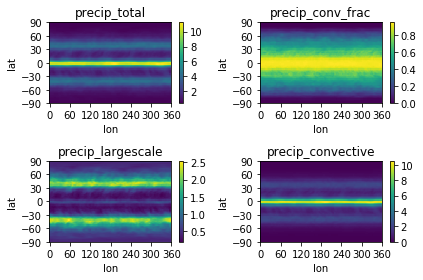

In [16]:
from matplotlib import pyplot as plt
%matplotlib inline

fig = plt.figure()

for i, calc in enumerate(calcs):
    ax = fig.add_subplot(2, 2, i+1)
    arr = calc.data_out['av']
    if calc.name != precip_conv_frac.name:
        arr *= 86400  # convert to units mm per day
    arr.plot(ax=ax)
    ax.set_title(calc.name)
    ax.set_xticks(range(0, 361, 60))
    ax.set_yticks(range(-90, 91, 30))

plt.tight_layout()

plt.show()

We see that precipitation maximizes at the equator and has a secondary maximum in the mid-latitudes. Also, the convective precipitation dominates the total in the Tropics, but moving poleward the gridscale condensation plays an increasingly larger fractional role (note different colorscales in each panel).

Regional averages
----------------

Now let's examine the regional averages. We find that the global annual mean total precipitation rate for this run (converting to units of mm per day) is:

In [17]:
for calc in calcs:
    ds = xr.Dataset(calc.data_out['reg.av'])
    if calc.name != precip_conv_frac.name:
        ds *= 86400  # convert to units mm/day
    print(calc.name, ds, '\n')

precip_total <xarray.Dataset>
Dimensions:              ()
Coordinates:
    raw_data_start_date  object 0004-01-01 00:00:00
    subset_start_date    object 0004-01-01 00:00:00
    raw_data_end_date    object 0007-01-01 00:00:00
    subset_end_date      object 0006-12-31 00:00:00
Data variables:
    tropics              float64 3.51
    globe                float64 3.025 

precip_conv_frac <xarray.Dataset>
Dimensions:              ()
Coordinates:
    raw_data_start_date  object 0004-01-01 00:00:00
    raw_data_end_date    object 0007-01-01 00:00:00
    subset_start_date    object 0004-01-01 00:00:00
    subset_end_date      object 0006-12-31 00:00:00
Data variables:
    tropics              float64 0.808
    globe                float64 0.598 

precip_largescale <xarray.Dataset>
Dimensions:              ()
Coordinates:
    raw_data_start_date  object 0004-01-01 00:00:00
    subset_start_date    object 0004-01-01 00:00:00
    raw_data_end_date    object 0007-01-01 00:00:00
    subset_end_

//anaconda/envs/aospy_dev/lib/python3.6/site-packages/xarray/core/dataset.py:374: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  both_data_and_coords = [k for k in data_vars if k in coords]


As was evident from the plots, we see that most precipitation (80.8%) in the tropics comes from convective rainfall, but averaged over the globe the large-scale condensation is a more equal player (40.2% for large-scale, 59.8% for convective).

Beyond this simple example
==============

Scaling up
----------
In this case, we computed time averages of four variables, both at each gridpoint (which we'll call 1 calculation) and averaged over two regions, yielding (4 variables)*(1 gridcell operation + (2 regions)*(1 regional operation)) = 12 total calculations executed. Not bad, but 12 calculations is few enough that we probably could have handled them without aospy.

The power of aospy is that, with the infrastructure we've put in place, we can now fire off additional calculations at any time. Some examples:

- Set `output_time_regional_reductions=['ts', 'std', 'reg.ts', 'reg.std']` : calculate the timeseries ('ts') and standard deviation ('std') of annual mean values at each gridpoint and for the regional averages.
- Set `output_time_intervals=range(1, 13)` : average across years for each January (1), each February (2), etc. through December (12).

With these settings, the number of calculations is now (4 variables)*(2 gridcell operations + (2 regions)*(2 regional operations))*(12 temporal averages) = 288 calculations submitted with a single command.

Modifying your object library
----------------------------

We can also add new objects to our object library at any time. For example, suppose we performed a new simulation in which we modified the formulation of the convective parameterization. All we would have to do is create a corresponding `Run` object, and then we can execute calculations for that simulation. And likewise for models, projects, variables, and regions.

As a real-world example, two of aospy's developers use aospy for in their own scientific research, with multiple projects each comprising multiple models, simulations, etc. They routinely fire off thousands of calculations at once. And thanks to the highly organized and metadata-rich directory structure and filenames of the aospy output netCDF files, all of the resulting data is easy to find and use.

Example "main" script
--------------------

Finally, aospy comes included with a "main" script for submitting calculations that is pre-populated with the objects from the example object library. It also comes with in-line instructions on how to use it, whether you want to keep playing with the example library or modify it to use on your own object library.

It is located in "examples" directory of your aospy installation. Find it via typing `python -c "import os, aospy; print(os.path.join(aospy.__path__[0], 'examples', 'aospy_main.py'))"` from your terminal.

In [18]:
# Optional: remove created files
import shutil
shutil.rmtree(example_proj.direc_out)